In [1]:
# This script is for GWR
# Take Dataset3 NYC for example

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pysal.model import mgwr
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\yhu42\yhu42\IDE\Anaconda\envs\py37\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\yhu42\yhu42\IDE\Anaconda\envs\py37\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
X_sociodemo_test_passed = pd.read_csv("../Data/01 Processed Dataset/Socio_NYC.csv", index_col = 'GEOID') # input
y = X_sociodemo_test_passed.pop('obesity_cr')
X_complete_test_passed = pd.read_csv("../Data/01 Processed Dataset/Complete_NYC.csv", index_col = "GEOID") # input
del X_complete_test_passed['obesity_cr']

In [3]:
X_sociodemo_test_passed.head()

,% Black,% Ame Indi and AK Native,% Asian,% Nati Hawa and Paci Island,% Hispanic or Latino,% male,% married,% age 18-29,% age 30-39,% age 40-49,...,% age >=60,% <highschool,median income,% unemployment,% below poverty line,% food stamp/SNAP,median value units built,median year units built,% renter-occupied housing units,population density
GEOID,,,,,,,,,,,,,,,,,,,,,
36081046200,0.128637,0.001426,0.405733,0.000000,0.324729,0.429122,0.443847,0.207074,0.149173,0.097119,...,0.198374,0.238825,53295,0.056929,0.086140,0.167808,566100,1964,0.776419,28106.912090
36081045000,0.078431,0.000000,0.579115,0.000000,0.191518,0.447788,0.534483,0.176015,0.133151,0.176471,...,0.204286,0.107830,90568,0.077815,0.071591,0.076923,585500,1939,0.326454,12744.813160
36081045400,0.160195,0.008653,0.628800,0.000000,0.101176,0.526514,0.550474,0.151986,0.135123,0.197471,...,0.170402,0.159578,45958,0.064898,0.147992,0.089735,168400,1954,0.558124,19521.893370
36081045600,0.028744,0.000000,0.708775,0.000000,0.142209,0.486384,0.604982,0.216339,0.116490,0.087746,...,0.288956,0.180612,76563,0.081081,0.170197,0.201201,650900,1939,0.279279,8153.246497
36081044602,0.197928,0.011224,0.427585,0.016836,0.298295,0.462335,0.505800,0.136844,0.189294,0.108353,...,0.123246,0.235081,40883,0.089128,0.325225,0.340757,281000,1957,0.869339,27255.666740


In [4]:
len(X_sociodemo_test_passed), len(X_complete_test_passed.columns)

(1995, 24)

In [5]:
# Standardization function
def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

In [6]:
X_sociodemo_test_passed_stats = X_sociodemo_test_passed.describe().transpose()
X_sociodemo_std_test_passed = standarize_data(X_sociodemo_test_passed, X_sociodemo_test_passed_stats)

X_complete_test_passed_stats = X_complete_test_passed.describe().transpose()
X_complete_std_test_passed = standarize_data(X_complete_test_passed, X_complete_test_passed_stats)

In [7]:
# Coordinates
ct_shp = gpd.read_file("../Data/05 Coordinates info for GWR/NYC_CDC data_Tract_Ob_pro.shp") # input
ct_shp['GEOID'] = ct_shp['GEOID'].astype('int64')

study_ct = X_sociodemo_std_test_passed.merge(ct_shp, on='GEOID', how='left')
study_ct['Lonpro'] = pd.to_numeric(study_ct['Lonpro']) 
study_ct['Latpro'] = pd.to_numeric(study_ct['Latpro']) 

lng_lat_coords = np.column_stack([study_ct['Lonpro'], study_ct['Latpro']])

In [12]:
ct_shp.head()

,GEOID,Lonpro,Latpro,geometry
0,36081046200,602380.0,4507260.0,"POLYGON ((602035.695 4507385.405, 602120.876 4..."
1,36081045000,600955.0,4507720.0,"POLYGON ((600694.356 4507904.676, 600707.087 4..."
2,36081045400,601697.0,4507560.0,"POLYGON ((601472.724 4507332.606, 601538.019 4..."
3,36081045500,596061.0,4510110.0,"POLYGON ((595765.028 4510141.191, 595796.122 4..."
4,36081045600,601862.0,4508000.0,"POLYGON ((601517.010 4508084.653, 601608.208 4..."


In [8]:
# Bandwidth
# https://mgwr.readthedocs.io/en/latest/api.html
socio_selector = mgwr.sel_bw.Sel_BW(lng_lat_coords, 
                                    np.asarray(y).reshape(-1,1), 
                                    np.asarray(X_sociodemo_std_test_passed), 
                                    spherical=False)

socio_bw = socio_selector.search(criterion='AICc') # golden section search; AIC; number of nearest neighbor
print(socio_bw)

220.0


In [13]:
# sociodemographic predictors
#fit GWR model
socio_gwr_model = mgwr.gwr.GWR(lng_lat_coords, 
                               np.asarray(y).reshape(-1,1), 
                               np.asarray(X_sociodemo_std_test_passed), 
                               socio_bw)

socio_gwr_results = socio_gwr_model.fit()
socio_gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1995
Number of covariates:                                                    22

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           9603.855
Log-likelihood:                                                   -4398.374
AIC:                                                               8840.748
AICc:                                                              8843.308
BIC:                                                              -5387.787
R2:                                                                   0.861
Adj. R2:                                                              0.860

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [14]:
#obtain prediction
y_gwr_socio_predict3 = socio_gwr_results.predy

#calculate RMSE
gwr_socio_rmse_3 = mean_squared_error(y , y_gwr_socio_predict3, squared=False)
print("RMSE of GWR with sociodemographic predictors: ", gwr_socio_rmse_3)

RMSE of GWR with sociodemographic predictors:  0.9263352239831926


In [11]:
complete_selector = mgwr.sel_bw.Sel_BW(lng_lat_coords, 
                                       np.asarray(y).reshape(-1,1),
                                       np.asarray(X_complete_std_test_passed),
                                       spherical=False)

complete_bw = complete_selector.search(criterion='AICc')
print(complete_bw)

242.0


In [15]:
X_complete_std_test_passed.columns

Index(['% Black', '% Ame Indi and AK Native', '% Asian',
       '% Nati Hawa and Paci Island', '% Hispanic or Latino', '% male',
       '% married', '% age 18-29', '% age 30-39', '% age 40-49', '% age 50-59',
       '% age >=60', '% <highschool', 'median income', '% unemployment',
       '% below poverty line', '% food stamp/SNAP', 'median value units built',
       'median year units built', '% renter-occupied housing units',
       'population density', 'fafood', 'fitness', 'park'],
      dtype='object')

In [16]:
# add diet and physical activity measurements
#fit GWR model
complete_gwr_model = mgwr.gwr.GWR(lng_lat_coords, 
                               np.asarray(y).reshape(-1,1), 
                               np.asarray(X_complete_std_test_passed),         
                               socio_bw) #using bw from bw search on demographic predictors

complete_gwr_results = complete_gwr_model.fit()
complete_gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1995
Number of covariates:                                                    25

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           9026.354
Log-likelihood:                                                   -4336.513
AIC:                                                               8723.026
AICc:                                                              8725.740
BIC:                                                              -5942.493
R2:                                                                   0.869
Adj. R2:                                                              0.868

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [17]:
#obtain prediction
y_gwr_complete_predict2 = complete_gwr_results.predy
#calculate RMSE
gwr_complete_rmse_2 = mean_squared_error(y , y_gwr_complete_predict2, squared=False)
print("RMSE of GWR adding alcohol visit predictors: ", gwr_complete_rmse_2)

RMSE of GWR adding alcohol visit predictors:  0.8981885421342738


11.0
43.4
12.268983288186192
44.76701182597628


<Figure size 720x576 with 0 Axes>

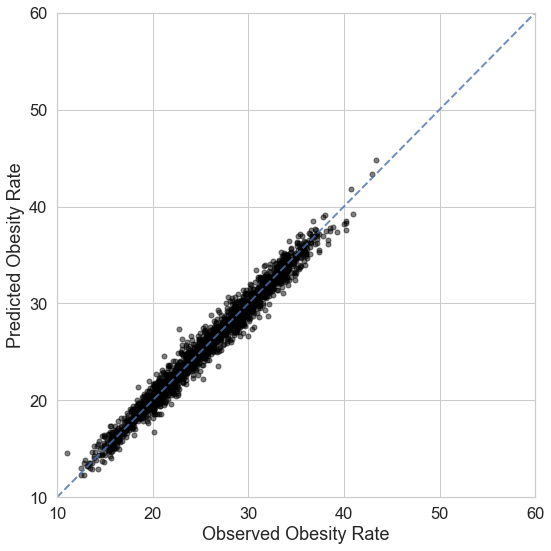

In [19]:
# GWR scatter-curve plot
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid",font_scale = 1.5)

def prediction_scatter(true_label, prediction, lims, title):
    plt.figure(figsize=(8,8))
    scatter = plt.plot(true_label, prediction, "o", markersize=5, alpha=0.5, color="black")
    line = plt.plot(lims, lims, "b--",alpha=0.8, linewidth=2)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Observed Obesity Rate')
    plt.ylabel('Predicted Obesity Rate')
    plt.title(title)
    
print(np.min(y))
print(np.max(y))
print(np.min(y_gwr_complete_predict2))
print(np.max(y_gwr_complete_predict2))

#scatter plot
lims = [10, 60]
prediction_scatter(y, y_gwr_complete_predict2, lims, "")
plt.tight_layout()
# plt.savefig("../GWR_pred_origin_NYC.png",dpi=300)

In [20]:
# Coefficient maps
feature_list = X_complete_std_test_passed.columns.tolist()
col_nam = ['const']+feature_list # const is like constant

#obtain coefficients from the GWR
df_coef = pd.DataFrame(
    data=complete_gwr_results.params,
    columns=col_nam,
    index=X_complete_std_test_passed.index
) 

# merge the geometry of CBG
ct_geometry = study_ct[['GEOID','geometry']]
df_coef = df_coef.merge(ct_geometry, on='GEOID',how='left')
gdf_coef = gpd.GeoDataFrame(df_coef, geometry='geometry')
gdf_place_coef = gdf_coef[['GEOID','fafood','fitness','park','geometry']]

# gdf_place_coef.to_file("../GWR_place_coef_NYC.shp")

In [21]:
gdf_place_coef.head()

,GEOID,fafood,fitness,park,geometry
0,36081046200,0.265473,-1.028229,-0.223844,"POLYGON ((602035.695 4507385.405, 602120.876 4..."
1,36081045000,0.272163,-0.538180,-0.293100,"POLYGON ((600694.356 4507904.676, 600707.087 4..."
2,36081045400,0.250023,-0.809012,-0.278053,"POLYGON ((601472.724 4507332.606, 601538.019 4..."
3,36081045600,0.261883,-0.835042,-0.315491,"POLYGON ((601517.010 4508084.653, 601608.208 4..."
4,36081044602,0.246946,-0.786448,-0.189827,"POLYGON ((601111.372 4507047.549, 601131.614 4..."
